<center> <h1> Target2 compound filtering into an unbiased dataset relative to source, microscope configuration and well and which are phenotypically active </h1> </center>

# 1) Merging table together

In [1]:
import polars as pl
import pandas as pd
from data_v2 import get_table
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from sklearn.preprocessing import RobustScaler
import get_features as gf
import plot_distribution_table as pdt
from features_engineering import features_drop_corr_gpu
from copairs.map import average_precision, mean_average_precision

In [2]:
compound = get_table("compound")
well = get_table("well")
plate = get_table("plate")
micro = get_table("microscope_config")
target2 = get_table("target2")
target2_plate = get_table("target2_plate")

In [3]:
# Removal of source_9 and source_1 because the plate is not similar
well = well.filter(pl.col("Metadata_Source").str.contains("_9|_1$") != True)

plate = plate.select(pl.all().exclude("Metadata_Source"))

micro_features = ['Metadata_Source','Metadata_Microscope_Name',
                  'Metadata_Widefield_vs_Confocal',
                  'Metadata_Excitation_Type',
                  'Metadata_Objective_NA',
                  'Metadata_Filter_Configuration']

#rename source so it is consistent with the other data
micro = micro.with_columns(
    ("source_" + pl.col("Metadata_Source").cast(str)).alias("Metadata_Source")).select(
    pl.col(micro_features))

#create a unique ID identifier per microscope configuration
micro = micro.filter(pl.col("Metadata_Source").str.contains("_[19]$|_15$") != True)
map_micro_ID = micro.select(pl.col("Metadata_Source"),
                            pl.struct(pl.all().exclude("Metadata_Source")).alias("unique"))\
                            .sort(by="unique")\
                            .select(pl.col("Metadata_Source"), pl.col("unique").rle_id().alias("Micro_id"))

micro = micro.join(map_micro_ID,
           on="Metadata_Source",
           how="left")

In [4]:
# check if InChIKey is a unique identifier
target2.group_by("InChIKey").agg(pl.all().n_unique()).with_columns(
    pl.sum_horizontal(pl.all().exclude("InChIKey"))).filter(pl.col("sum")>8)

InChIKey,broad_sample,pert_iname,pubchem_cid,target,pert_type,control_type,smiles,InChI,sum
str,u32,u32,u32,u32,u32,u32,u32,u32,u32
"""GJFCONYVAUNLKB…",2,1,2,1,1,1,1,1,10
"""UTBOEBCWXGDOGI…",2,1,2,1,1,1,1,1,10
"""LOUPRKONTZGTKE…",2,2,2,2,1,1,1,1,12
"""AJVXVYTVAAWZAP…",2,1,2,1,1,1,1,1,10
"""QIHBWVVVRYYYRO…",2,1,2,1,1,1,1,1,10


Here we can notice that InChIKey is not a unique identifier. We should remove duplicates to avoid complication later on.

broad_sample, pubchem_cid can be removed without hesitation (not useful next for mergin etc.) pert_iname and target (target can give insight on moa or it can be another way to group sample than moa. and pert_iname is how we're going to merge moa and our table at the end) can still be informative so we should deal with this sample: "LOUPRKONTZGTKE..."

In [5]:
target2.filter(pl.col("InChIKey").str.contains("LOUPRKONTZGTKE"))

broad_sample,InChIKey,pert_iname,pubchem_cid,target,pert_type,control_type,smiles,InChI
str,str,str,i64,str,str,str,str,str
"""BRD-K48278478-…","""LOUPRKONTZGTKE…","""quinine""",94175,"""KCNN4""","""trt""","""NA""","""C=CC1CN2CCC1CC…","""InChI=1S/C20H2…"
"""BRD-K59632282-…","""LOUPRKONTZGTKE…","""quinidine""",441074,"""KCNK1""","""trt""","""NA""","""C=CC1CN2CCC1CC…","""InChI=1S/C20H2…"


When looking at the following website, the InChiKey is supposed to be different: 
* quinidine:
  - [LOUPRKONTZGTKE-WGFDLZGGSA-N](https://webbook.nist.gov/cgi/inchi?ID=C56542) (from webbook chemistry NIST)
  - [LOUPRKONTZGTKE-LHHVKLHASA-N](https://pubchem.ncbi.nlm.nih.gov/compound/Quinidine#section=Crystal-Structures) (from PubChem NIH)
* quinine:
  - [LOUPRKONTZGTKE-UHFFFAOYSA-N](https://webbook.nist.gov/cgi/inchi/InChI%3D1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10-19(22)20(23)16-6-8-21-18-5-4-15(24-2)11-17(16)18/h3-6%2C8%2C11%2C13-14%2C19-20%2C23H%2C1%2C7%2C9-10%2C12H2%2C2H3) (from webbook chemistry NIST)
  - [LOUPRKONTZGTKE-WZBLMQSHSA-N](https://pubchem.ncbi.nlm.nih.gov/compound/Quinine#section=Computed-Descriptors) (from PubChem NIH)

The difference happens to be within the 8 digits which account for the stereochemistry cf [original_paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0068-4/figures/7), for instance: "LHHVKLHA".

Let's see the one chosen in Target2 and the amount of different digits in compound. 

In [6]:
target2.filter(pl.col("InChIKey").str.contains("LOUPRKONTZGTKE")).select(
    pl.col("InChIKey").unique()).to_numpy()

array([['LOUPRKONTZGTKE-UHFFFAOYSA-N']], dtype=object)

In [7]:
# We want to see how does that compare to the original table compound
compound.select(pl.col("Metadata_InChIKey").str.extract("\w+-(\w{8}SA)-").unique())

Metadata_InChIKey
str
"""UHFFFAOYSA"""
null
"""QOPSANPBSA"""


In [8]:
# exclude quinidine
target2 = target2.filter(pl.col("broad_sample").str.contains("BRD-K59632282-") != True)
# remove broad_sample and pubchem_id which are no use
target2 = target2.select(pl.all().exclude(["broad_sample", "pubchem_cid"])).unique()

# finally merge tables together
merge_table = compound.join(well, on=pl.col("Metadata_JCP2022"), how="inner")\
.join(plate, on=pl.col("Metadata_Plate"), how="inner")\
.join(micro, on=pl.col("Metadata_Source"), how="inner")\
.join(target2,left_on=pl.col("Metadata_InChIKey"), right_on=pl.col("InChIKey"), how="inner")

merge_table = merge_table.unique()

# 2) Retrieve replicates with moa and features
Before doing anything, let's retrieve the features and moa to see which compound has actually their features or moa available. 
## a) features

In [9]:
features = gf.load_features('COMPOUND', merge_table.lazy())
print(" Using Target2:\n"
" feature shape:",
f"{features.select(pl.count()).collect().item()}\n",
f"metadata shape: {merge_table.shape[0]}")

 Using Target2:
 feature shape: 149429
 metadata shape: 212865


In [10]:
merge_table = merge_table.join(features.select(pl.col("^Metadata.*$")).collect(),
              on=["Metadata_Source", "Metadata_Plate", "Metadata_Well", "Metadata_JCP2022"],
              how="inner")

## b) MoA

In [11]:
moa_table = pl.read_csv("https://s3.amazonaws.com/data.clue.io/repurposing/downloads/repurposing_drugs_20200324.txt",
            separator="\t",
            comment_prefix="!")
moa = moa_table.select(pl.col("pert_iname", "moa")).unique().drop_nulls()

In [12]:
merge_table = merge_table.join(moa,
                               on="pert_iname",
                               how="inner")

# 3) Restrict the number of DMSO based on plate provenance

In [13]:
print("original_table: {}".format(
    merge_table.select(pl.all().n_unique()).select(pl.col(["Metadata_Plate", "Metadata_Batch"]))))
print("DMSO_table: {}".format(
    merge_table.filter(pl.col("pert_iname") == "DMSO").select(pl.all().n_unique())
    .select(pl.col(["Metadata_Plate", "Metadata_Batch"]))))
print("poscon_table: {}".format(
    merge_table.filter((pl.col("pert_iname") != "DMSO") & (pl.col("pert_type") != "trt")).select(pl.all().n_unique())
    .select(pl.col(["Metadata_Plate", "Metadata_Batch"]))))
print("trt_table: {}".format(
    merge_table.filter(pl.col("pert_type") == "trt").select(pl.all().n_unique())
    .select(pl.col(["Metadata_Plate", "Metadata_Batch"]))))

original_table: shape: (1, 2)
┌────────────────┬────────────────┐
│ Metadata_Plate ┆ Metadata_Batch │
│ ---            ┆ ---            │
│ u32            ┆ u32            │
╞════════════════╪════════════════╡
│ 1557           ┆ 107            │
└────────────────┴────────────────┘
DMSO_table: shape: (1, 2)
┌────────────────┬────────────────┐
│ Metadata_Plate ┆ Metadata_Batch │
│ ---            ┆ ---            │
│ u32            ┆ u32            │
╞════════════════╪════════════════╡
│ 1554           ┆ 106            │
└────────────────┴────────────────┘
poscon_table: shape: (1, 2)
┌────────────────┬────────────────┐
│ Metadata_Plate ┆ Metadata_Batch │
│ ---            ┆ ---            │
│ u32            ┆ u32            │
╞════════════════╪════════════════╡
│ 1514           ┆ 107            │
└────────────────┴────────────────┘
trt_table: shape: (1, 2)
┌────────────────┬────────────────┐
│ Metadata_Plate ┆ Metadata_Batch │
│ ---            ┆ ---            │
│ u32            ┆ u32     

We should have the same number of plate and same number of batch so let's retrieve the correct plate and batch
The difference occur between DMSO and the other compound (no need to separate poscon from trt)

In [14]:
common_plate_batch = (merge_table.filter(pl.col("pert_iname") != "DMSO") #retrieve plate&batch from trt and poscon
                      .select("Metadata_Plate", "Metadata_Batch").unique()
                      .join(merge_table.filter(pl.col("pert_iname") == "DMSO") #retrieve plate&batch from DMSO and join
                            .select("Metadata_Plate", "Metadata_Batch").unique(),
                            on=["Metadata_Plate", "Metadata_Batch"],
                            how="inner"))
merge_table = merge_table.join(common_plate_batch,
                               on=["Metadata_Plate", "Metadata_Batch"],
                               how="inner")

# 4) Retrieve phenotypically active compound using mAP

In [15]:
# # collect features
# features = gf.load_features('COMPOUND', merge_table.lazy()).collect()

In [16]:
# #remove metadata
# features = features[:, 4:]

In [17]:
# # transfer to pandas
# features_df = features.to_pandas()
# metadata_df = merge_table.to_pandas()

# features_df = features_df[features_df.columns[(features_df.isna().sum(axis=0) == 0) & 
#                                             ((features_df == np.inf).sum(axis=0) == 0)]]
# features_df = features_df[features_df.columns[(features_df.std() != 0)]]
# metadata_df = metadata_df.assign(
#     trt_dmso=metadata_df["pert_iname"].where(metadata_df["pert_iname"] == "DMSO", other="trt"))
# metadata_df["ID"] = metadata_df.index

In [18]:
# features_df = features_drop_corr_gpu(threshold=0.95).fit_transform(features_df)

In [2]:
# features_df.to_parquet("Target2_large_set_features")
# metadata_df.to_parquet("Target2_large_set_metadata")
features_df = pd.read_parquet("Target2_large_set_features")
metadata_df = pd.read_parquet("Target2_large_set_metadata")

In [3]:
#trick to avoid computing dmso positive pair
metadata_df["trt_index"] = metadata_df.index
metadata_df.loc[metadata_df["pert_iname"] == "DMSO", "trt_index"] = -1

In [4]:
dmso_scaler = RobustScaler().fit(features_df[metadata_df["trt_dmso"] == "DMSO"])
features_df = dmso_scaler.transform(features_df)

In [5]:
import logging
import warnings
logging.basicConfig(format="%(levelname)s:%(asctime)s:%(name)s:%(message)s")
logging.getLogger("copairs").setLevel(logging.INFO)

warnings.simplefilter(action="ignore", category=FutureWarning)

## Question ? 
Since we are doing a restriction on the source or on the batch. Do we need to balance things out ? So there is somewhat the same level of restriction for every one ? Anyway, pretty much the same number of DMSO in every source


Shouldn't we restrict the positive pair as well within the same restriction as the negative pair to get somewhat the same significance ? 
Again because of the batch effect: This would mean that within a same batch for this compound, I can easily retrieve this replicate.
But what we actually want is : within this group of compound, which replicate should we drop because they look too much like DMSO. So to my opinion, no need to restrict the positive pair.

In [ ]:
pos_sameby = ["Metadata_InChIKey"]  # We want to match perturbations
pos_diffby = ["trt_index"]#["ID"]
neg_sameby = []#["Metadata_Source"]#["Metadata_Batch"]
neg_diffby = ["trt_dmso"]
batch_size = 20000


result = average_precision(
    metadata_df,
    features_df,#.to_numpy(),
    pos_sameby,
    pos_diffby,
    neg_sameby,
    neg_diffby,
    batch_size,
)

# sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")
# result = result[result["trt_dmso"] != "DMSO"]

INFO:2024-09-24 22:31:29,254:copairs:Indexing metadata...
INFO:2024-09-24 22:31:29,465:copairs:Finding positive pairs...
INFO:2024-09-24 22:33:33,019:copairs:Finding negative pairs...


In [ ]:
result.to_parquet("Target2_average_precision_total")

<Axes: xlabel='average_precision', ylabel='Metadata_InChIKey'>

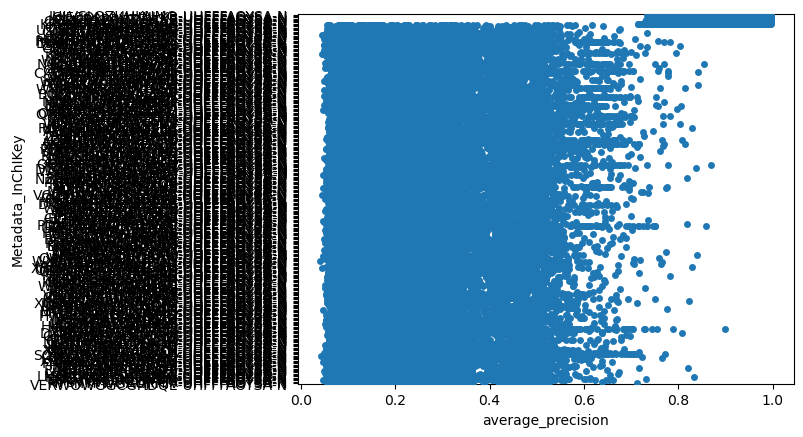

In [116]:
result = pd.read_parquet("Target2_average_precision_plate")
result = result[result["trt_dmso"] != "DMSO"]
sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")
# result = result[result["trt_dmso"] != "DMSO"]

In [132]:
mAP_batch = mean_average_precision(result, ["ID"], null_size=50000, threshold=0.05, seed=42)
mAP_batch["-log10(p-value)"] = -mAP_batch["corrected_p_value"].apply(np.log10)
# mAP[mAP["below_corrected_p"] == True]

INFO:2024-09-24 21:54:45,014:copairs:Computing null_dist...


  0%|          | 0/2066 [00:00<?, ?it/s]

INFO:2024-09-24 21:54:45,435:copairs:Computing p-values...


  0%|          | 0/77974 [00:00<?, ?it/s]

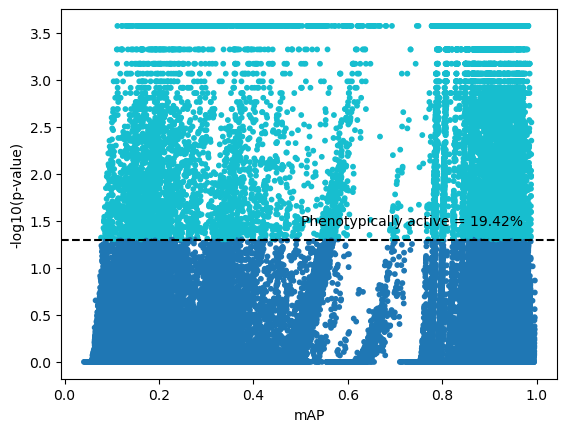

In [133]:
active_ratio = mAP_batch.below_corrected_p.mean()

plt.scatter(data=mAP_batch, x="mean_average_precision", y="-log10(p-value)", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.5, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left")
plt.show()

<Axes: xlabel='average_precision', ylabel='Metadata_InChIKey'>

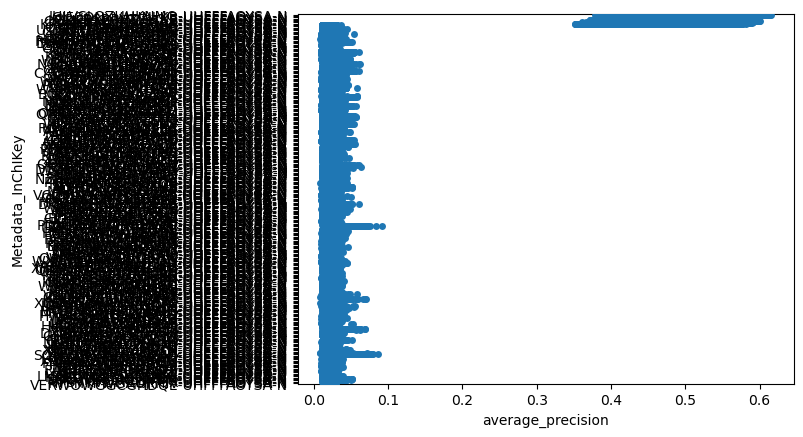

In [9]:
result = pd.read_parquet("Target2_average_precision_source")
result = result[result["trt_dmso"] != "DMSO"]
sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")

In [10]:
mAP_source = mean_average_precision(result, ["ID"], null_size=20000, threshold=0.05, seed=42)
mAP_source["-log10(p-value)"] = -mAP_source["corrected_p_value"].apply(np.log10)

INFO:2024-09-24 22:23:23,681:copairs:Computing null_dist...


  0%|          | 0/391 [00:00<?, ?it/s]

INFO:2024-09-24 22:24:52,904:copairs:Computing p-values...


  0%|          | 0/77974 [00:00<?, ?it/s]

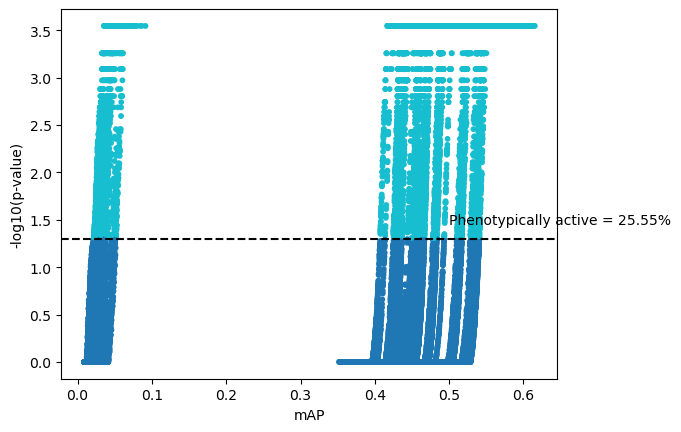

In [11]:
active_ratio = mAP_source.below_corrected_p.mean()

plt.scatter(data=mAP_source, x="mean_average_precision", y="-log10(p-value)", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.5, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left")
plt.show()

,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,...,pert_iname,target,pert_type,control_type,smiles,InChI,moa,trt_dmso,ID,trt_index
1,JCP2022_035095,IHLVSLOZUHKNMQ-UHFFFAOYSA-N,InChI=1S/C26H27N5O2/c1-2-9-27-22(4-1)26-25(24-...,source_10,Dest210531-152459,E01,2021_05_31_U2OS_48_hr_run1,COMPOUND,CV8000,Confocal,...,LY2109761,TGFBR1,trt,NA,c1ccc(-c2nn3c(c2-c2ccnc4cc(OCCN5CCOCC5)ccc24)C...,InChI=1S/C26H27N5O2/c1-2-9-27-22(4-1)26-25(24-...,TGF beta receptor inhibitor,trt,1,1
2,JCP2022_025848,GJFCONYVAUNLKB-UHFFFAOYSA-N,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,source_10,Dest210531-152459,K01,2021_05_31_U2OS_48_hr_run1,COMPOUND,CV8000,Confocal,...,dexamethasone,ANXA1,trt,NA,CC1CC2C3CC=C4CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,glucocorticoid receptor agonist,trt,2,2
3,JCP2022_012818,CQKBSRPVZZLCJE-UHFFFAOYSA-N,InChI=1S/C23H17Cl2N5O4/c1-34-23-27-11-14-8-16(...,source_10,Dest210531-152810,L24,2021_05_31_U2OS_48_hr_run1,COMPOUND,CV8000,Confocal,...,TC-S-7004,DYRK1B,control,poscon_cp,COc1ncc2cc(C(=O)Nc3cc(C(=O)NCc4cccc(Cl)c4)ccc3...,InChI=1S/C23H17Cl2N5O4/c1-34-23-27-11-14-8-16(...,DYRK inhibitor,trt,3,3
18,JCP2022_050797,LOUPRKONTZGTKE-UHFFFAOYSA-N,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,source_10,Dest210608-151243,C24,2021_06_08_U2OS_48_hr_run4,COMPOUND,CV8000,Confocal,...,quinine,KCNN4,trt,NA,C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,hemozoin biocrystallization inhibitor,trt,18,18
21,JCP2022_064022,OINGHOPGNMYCAB-UHFFFAOYSA-N,InChI=1S/C23H25ClF3N5O/c1-13(2)28-23(33)31-8-7...,source_10,Dest210608-152745,J24,2021_06_08_U2OS_48_hr_run4,COMPOUND,CV8000,Confocal,...,NVS-PAK1-1,PAK1,control,poscon_cp,CC(C)NC(=O)N1CCC(N=C2Nc3cc(F)ccc3N(CC(F)F)c3cc...,InChI=1S/C23H25ClF3N5O/c1-13(2)28-23(33)31-8-7...,p21 activated kinase inhibitor,trt,21,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130811,JCP2022_012818,CQKBSRPVZZLCJE-UHFFFAOYSA-N,InChI=1S/C23H17Cl2N5O4/c1-34-23-27-11-14-8-16(...,source_8,A1170519,P01,J3,COMPOUND,ImageXpress Micro Confocal,Confocal,...,TC-S-7004,DYRK1B,control,poscon_cp,COc1ncc2cc(C(=O)Nc3cc(C(=O)NCc4cccc(Cl)c4)ccc3...,InChI=1S/C23H17Cl2N5O4/c1-34-23-27-11-14-8-16(...,DYRK inhibitor,trt,130811,130811
130812,JCP2022_035095,IHLVSLOZUHKNMQ-UHFFFAOYSA-N,InChI=1S/C26H27N5O2/c1-2-9-27-22(4-1)26-25(24-...,source_8,A1170521,I24,J3,COMPOUND,ImageXpress Micro Confocal,Confocal,...,LY2109761,TGFBR1,trt,NA,c1ccc(-c2nn3c(c2-c2ccnc4cc(OCCN5CCOCC5)ccc24)C...,InChI=1S/C26H27N5O2/c1-2-9-27-22(4-1)26-25(24-...,TGF beta receptor inhibitor,trt,130812,130812
130813,JCP2022_025848,GJFCONYVAUNLKB-UHFFFAOYSA-N,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,source_8,A1170530,O24,J3,COMPOUND,ImageXpress Micro Confocal,Confocal,...,dexamethasone,ANXA1,trt,NA,CC1CC2C3CC=C4CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,glucocorticoid receptor agonist,trt,130813,130813
130815,JCP2022_046054,KPBNHDGDUADAGP-UHFFFAOYSA-N,InChI=1S/C24H29N3O2/c28-23(12-11-21-8-6-15-25-...,source_8,A1170534,H24,J3,COMPOUND,ImageXpress Micro Confocal,Confocal,...,FK-866,NAMPT,control,poscon_diverse,O=C(C=Cc1cccnc1)NCCCCC1CCN(C(=O)c2ccccc2)CC1,InChI=1S/C24H29N3O2/c28-23(12-11-21-8-6-15-25-...,niacinamide phosphoribosyltransferase inhibitor,trt,130815,130815


In [16]:
trt_inchi = metadata_df[metadata_df["trt_dmso"] != "DMSO"]["Metadata_InChIKey"].unique()
dmso_inchi = metadata_df[metadata_df["trt_dmso"] == "DMSO"]["Metadata_InChIKey"].unique()

In [17]:
batch = 10
metadata_df["Metadata_InChIKey"].isin(trt_inchi[:batch])

0         False
1          True
2          True
3          True
4         False
          ...  
130817    False
130818    False
130819    False
130820    False
130821    False
Name: Metadata_InChIKey, Length: 130822, dtype: bool

In [ ]:
pos_sameby = ["Metadata_InChIKey"]  # We want to match perturbations
pos_diffby = ["trt_index"]#["ID"]
neg_sameby = []#["Metadata_Source"]#["Metadata_Batch"]
neg_diffby = ["trt_dmso"]
batch_size = 20000


result = average_precision(
    metadata_df,
    features_df,#.to_numpy(),
    pos_sameby,
    pos_diffby,
    neg_sameby,
    neg_diffby,
    batch_size,
)

# sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")
# result = result[result["trt_dmso"] != "DMSO"]

In [ ]:
result.to_parquet("Target2_average_precision_total")

In [ ]:
result = pd.read_parquet("Target2_average_precision_total")
result = result[result["trt_dmso"] != "DMSO"]
sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")

In [ ]:
mAP_source = mean_average_precision(result, ["ID"], null_size=20000, threshold=0.05, seed=42)
mAP_source["-log10(p-value)"] = -mAP_source["corrected_p_value"].apply(np.log10)